# Import packages

In [1]:
import os
import numpy as np
# import ipdb
import time
from tqdm import tqdm
import datetime
import pandas as pd
import logging
from pathlib import Path
import matplotlib.pyplot as plt
import math

# torchvision for image loading
import torchvision
from torchvision import datasets, models
import torchvision.transforms.v2 as tr
import torchvision.transforms.v2.functional as trf

from torch.utils.data import DataLoader

# for transformations
import torchvision.transforms.v2 as tr
import torchvision.transforms.v2.functional as trf

# torch for model creation
import torch
import torch.nn as nn

# for model evaluation
import torcheval.metrics.functional as metf
from sklearn.metrics import precision_score, recall_score

#sklearn for data splitting
from sklearn.model_selection import train_test_split

import sys

sys.path.append(os.path.join(os.getcwd(), "Datasetting"))
from Setdata import EcoTaxaDataset, transform_vignettes_valid, FocalLoss, remove_missing_or_empty_images

sys.path.append(os.path.join(os.getcwd(), "PyramidNetPyTorch"))
from PyramidNet import PyramidNet

sys.path.append(os.path.join(os.getcwd(), "Loadingmodels"))
from Loading_models import initialize_model

sys.path.append(os.path.join(os.getcwd(), "Trainingmodels"))
from Training_models import train_model
from Find_best_lr import find_optimal_lr
from Create_confusion_matrix import log_confusion_matrix

# Auto lr finding
from torch_lr_finder import LRFinder

# Import mlflow dor data visualization
import mlflow

/home/coicaudtou/.conda/envs/Classification_UVP6_py310_v2/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Import Data

## Config

In [2]:
# Set mlflow
mlflow.set_tracking_uri("http://192.168.77.70:6000")

In [3]:
# root of the project
try:
    base_dir = Path(__file__).resolve().parent
except NameError:
    base_dir = Path("/home/coicaudtou/myspace/Classify_ANERIS")

# relative folders
data_dir = base_dir / "Data"
tsv_path = data_dir / "stacked_anerissmartbay_training.tsv"
output_root = base_dir / "Outputs" / "dataset_split"
train_dir = base_dir / "Outputs"/ "output_training"
log_dir = base_dir / "Outputs" / "log"

RANDOM_STATE = 123

# prepare loggers
log = logging.getLogger()
log.setLevel(logging.INFO)

    # define the output format for log messages
log_formatter = logging.Formatter('%(asctime)s.%(msecs)03d\t%(message)s',\
                                  datefmt='%Y-%m-%dT%H:%M:%S')

    # log to console
console_handler = logging.StreamHandler()
console_handler.setFormatter(log_formatter)
log.addHandler(console_handler)

    # prepare logging to file (activated just before the training loop)
log_file = os.path.join(log_dir, 'log.tsv')
file_handler = logging.FileHandler(log_file)
file_handler.setFormatter(log_formatter)

## Splitting of the data

In [4]:
# splits ratios
train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2

# ---Load metadata
df = pd.read_csv(tsv_path, sep="\t", engine="python")
# Classes to exclude 
other_to_live = [
    "Trisopterus minutus",
    "reflection",
    "egg sac<egg",
    "t004",
    "Cnidaria<Metazoa",
    "Echinodermata"
]

# Classes to gather to the upper taxonomic group
recode_dict = {
    "Swima": "Annelida",
    "Syngnathiformes": "Actinopterygii",
    "Narcomedusae": "Hydrozoa",
    "Trachymedusae": "Hydrozoa",
    "Appendicularia": "house"
}

# Add to rare classes → "othertocheck"
recode_dict.update({k: "othertocheck" for k in other_to_live})

df = df[
    (df["img_rank"] == 100)
]

# Classes to gather
df["object_annotation_category"] = (
    df["object_annotation_category"]
        .replace(recode_dict)
)
print("Available columns :", df.columns.tolist())

# convert classes to integer indexes
classes = np.unique(df['object_annotation_category'])
class_to_idx = {cls: i for i, cls in enumerate(classes)}
idx_to_class = {i: cls for cls, i in class_to_idx.items()}

# compute class weights
class_counts = df['object_annotation_category'].value_counts().sort_index()
max_count = np.max(class_counts)

#weight_sensitivity = 0.25
#class_weights = ((max_count / class_counts)**weight_sensitivity).to_numpy()

# ---Create splits
samples = list(set(df['object_date']))

samples_train, samples_temp = train_test_split(samples, test_size=(1-train_ratio), random_state= RANDOM_STATE, shuffle=False)
samples_val, samples_test = train_test_split(samples_temp, test_size=(test_ratio/(test_ratio+val_ratio)), random_state=RANDOM_STATE, shuffle=False)

# ---Create associated DataFrames
#train_df = df[df['object_date'].isin(samples_train)].reset_index(drop=True)
#val_df   = df[df['object_date'].isin(samples_val)].reset_index(drop=True)
#test_df  = df[df['object_date'].isin(samples_test)].reset_index(drop=True)

#train_df.to_csv(os.path.join(output_root, "train_vilanova.csv"), index=False)
#val_df.to_csv(os.path.join(output_root, "val_vilanova.csv"), index=False)
#test_df.to_csv(os.path.join(output_root, "test_vilanova.csv"), index=False)

train_df = pd.read_csv(os.path.join(output_root, "train_smartbay.csv"), sep=",", engine="python")
val_df = pd.read_csv(os.path.join(output_root, "val_smartbay.csv"), sep=",", engine="python")
test_df = pd.read_csv(os.path.join(output_root, "test_smartbay.csv"), sep=",", engine="python")

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

#For training merge train and val
train_df = pd.concat([train_df, val_df], axis=0)

# ---Save Df
os.makedirs(output_root, exist_ok=True)
print(f"CSV files created in : {os.path.abspath(output_root)}")

Available columns : ['img_file_name', 'img_rank', 'object_id', 'object_lat', 'object_lon', 'object_date', 'object_time', 'object_link', 'object_depth_min', 'object_depth_max', 'object_annotation_status', 'object_annotation_person_name', 'object_annotation_person_email', 'object_annotation_date', 'object_annotation_time', 'object_annotation_category', 'object_annotation_hierarchy']
Train: 73915, Val: 28595, Test: 15073
CSV files created in : /home/coicaudtou/myspace/Classify_ANERIS/Outputs/dataset_split


In [6]:
len(train_df)

102510

## Set data

In [5]:
# ---Setup list of paths and labels
train_paths = [os.path.join(data_dir, fname) for fname in train_df["img_file_name"]]
val_paths   = [os.path.join(data_dir, fname) for fname in val_df["img_file_name"]]
test_paths  = [os.path.join(data_dir, fname) for fname in test_df["img_file_name"]]

train_labels = train_df["object_annotation_category"].tolist()
val_labels   = val_df["object_annotation_category"].tolist()
test_labels  = test_df["object_annotation_category"].tolist()

# ---Remove missing image files
train_paths, train_labels = remove_missing_or_empty_images(train_paths, train_labels)
val_paths, val_labels = remove_missing_or_empty_images(val_paths, val_labels)
test_paths, test_labels = remove_missing_or_empty_images(test_paths, test_labels)

# ---Define transformations
train_transform = lambda img: transform_vignettes_valid(img, data_augmentation=True)
val_transform   = lambda img: transform_vignettes_valid(img, data_augmentation=False)
test_transform  = lambda img: transform_vignettes_valid(img, data_augmentation=False)

# ---Create Datasets
train_dataset = EcoTaxaDataset(train_paths, train_labels, class_to_idx, idx_to_class, transform=train_transform)
val_dataset   = EcoTaxaDataset(val_paths, val_labels, class_to_idx, idx_to_class, transform=val_transform)
test_dataset  = EcoTaxaDataset(test_paths, test_labels, class_to_idx, idx_to_class, transform=test_transform)

✅ 102510 fichiers valides sur 102510
✅ 28595 fichiers valides sur 28595
✅ 15073 fichiers valides sur 15073


## Have a look at the transformation

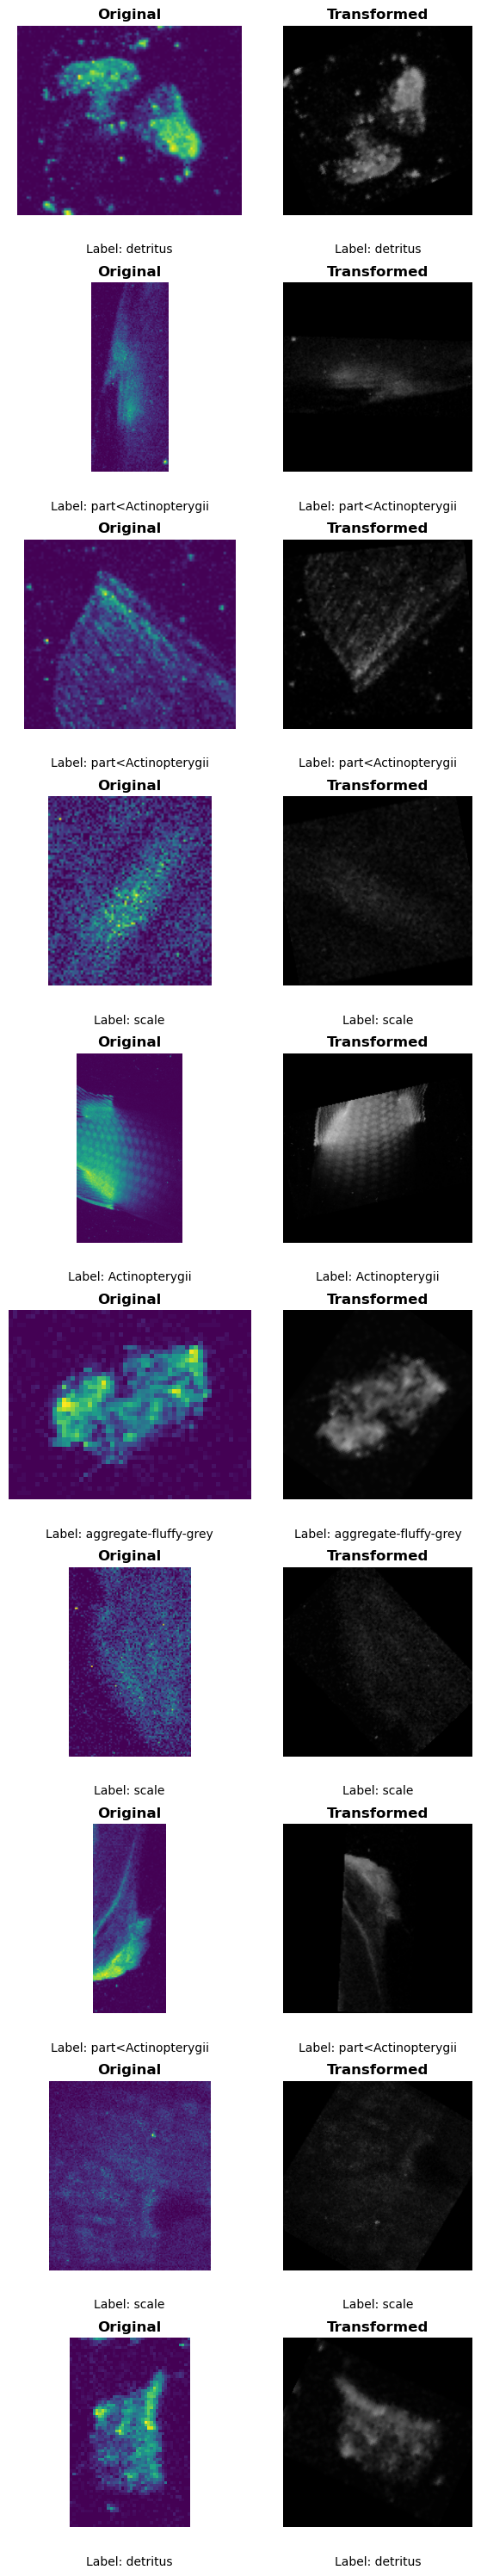

In [9]:
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as F
from torchvision.io import read_image

# Sélection aléatoire de 10 chemins d'images
sample_df = test_df.sample(10, random_state=42)
sample_paths = [os.path.join(data_dir, fname) for fname in sample_df["img_file_name"]]
sample_labels = sample_df["object_annotation_category"].tolist()

# Figure
fig, axes = plt.subplots(10, 2, figsize=(6, 30))

for i, (path, label) in enumerate(zip(sample_paths, sample_labels)):
    # Lecture de l'image brute
    img = read_image(path)
    img_before = F.to_pil_image(img)

    # Transformation
    img_after = F.to_pil_image(train_transform(img))

    # Original
    axes[i, 0].imshow(img_before)
    axes[i, 0].set_title("Original", fontsize=12, fontweight='bold')
    axes[i, 0].text(
        0.5, -0.15, f"Label: {label}",
        fontsize=10, ha='center', va='top', transform=axes[i, 0].transAxes
    )
    axes[i, 0].axis("off")

    # Transformée
    axes[i, 1].imshow(img_after)
    axes[i, 1].set_title("Transformed", fontsize=12, fontweight='bold')
    axes[i, 1].text(
        0.5, -0.15, f"Label: {label}",
        fontsize=10, ha='center', va='top', transform=axes[i, 1].transAxes
    )
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

## Dataloading

In [6]:
# ---Create Dataloaders
batch_size = 32
n_cores = 8

log.info(f'Dataloading')

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cores, pin_memory=True)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cores, pin_memory=True)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cores, pin_memory=True)

# ---Print infos
print(f"Nombre de classes : {len(class_to_idx)}")
print(f"Nombre de classes dans le valid set : {len(np.unique(val_labels))}")
print(f"Exemple de classes : {list(class_to_idx.keys())[:5]}")
print(f"Train batches : {len(train_dataloader)}, Val batches : {len(val_dataloader)}, Test batches : {len(test_dataloader)}")

dataloaders = {
    'train': train_dataloader,
    'valid': val_dataloader,
    'test': test_dataloader 
}

class_names = list(class_to_idx.keys())
n_classes= len(class_to_idx)

2025-12-18T12:45:35.183	Dataloading
2025-12-18T12:45:35.183	Dataloading


Nombre de classes : 30
Nombre de classes dans le valid set : 24
Exemple de classes : ['Actinopterygii', 'Amphipoda', 'Annelida', 'Brachyura', 'Chaetognatha']
Train batches : 3204, Val batches : 894, Test batches : 472


## Check the completness of your dataset

In [10]:
import os

def check_dataset_paths(dataset, name="dataset", max_display=5):
    """
    Vérifie que tous les chemins d'images du dataset existent.
    Affiche un résumé et quelques exemples de fichiers manquants.
    """
    print(f"🔍 Vérification des chemins pour {name} ...")

    missing = [p for p in dataset.paths if not os.path.exists(p)]

    if len(missing) == 0:
        print(f"✅ Tous les fichiers du {name} existent ({len(dataset.paths)} fichiers).")
    else:
        print(f"❌ {len(missing)} fichiers manquants sur {len(dataset.paths)} dans {name}.")
        print("Exemples de fichiers introuvables :")
        for p in missing[:max_display]:
            print("  -", p)
        print("💡 Vérifie ton data_dir ou la structure de tes chemins relatifs.")


In [11]:
check_dataset_paths(train_dataset, "train_dataset")
check_dataset_paths(val_dataset, "val_dataset")
check_dataset_paths(test_dataset, "test_dataset")

🔍 Vérification des chemins pour train_dataset ...
✅ Tous les fichiers du train_dataset existent (61521 fichiers).
🔍 Vérification des chemins pour val_dataset ...
✅ Tous les fichiers du val_dataset existent (14910 fichiers).
🔍 Vérification des chemins pour test_dataset ...
✅ Tous les fichiers du test_dataset existent (8819 fichiers).


# Start MLflow

In [7]:
print("torch.cuda.is_available():", torch.cuda.is_available())
print("Nombre de GPU:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Nom GPU:", torch.cuda.get_device_name(0))

torch.cuda.is_available(): True
Nombre de GPU: 1
Nom GPU: NVIDIA RTX 6000 Ada Generation


## Define selected parameters

In [8]:
search_space = {
    "learning_rate": ["AUTO/10"],# AUTO = use opti_lr[0.95, 0.5]
    "scheduler_gamma": [1],
    "sensitivity":[0.25],
    "gamma":[1]
}

import itertools

def grid_search(space):
    keys = space.keys()
    for values in itertools.product(*space.values()):
        yield dict(zip(keys, values))


2025-12-18T12:45:41.757	Initializing mobilenet_v3_large + one_layer for LR search…
2025-12-18T12:45:41.757	Initializing mobilenet_v3_large + one_layer for LR search…


Running LR Finder...


  0%|          | 0/120 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
Suggested learning rate: 1.42e-04
LR suggestion: steepest gradient
Suggested LR: 1.56E-04


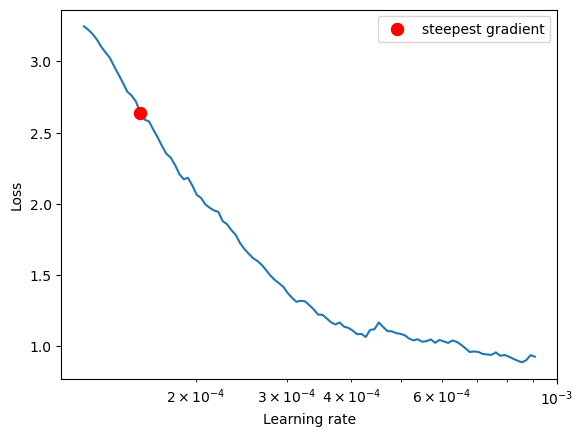

2025-12-18T12:45:52.535	Optimal LR for mobilenet_v3_large+one_layer: 1.42e-04
2025-12-18T12:45:52.535	Optimal LR for mobilenet_v3_large+one_layer: 1.42e-04
2025-12-18T12:45:52.591	Training mobilenet_v3_large with one_layer, lr=1.416643274669021e-05, CrossEntropyLoss, weight_sensitivity=0.25
2025-12-18T12:45:52.591	Training mobilenet_v3_large with one_layer, lr=1.416643274669021e-05, CrossEntropyLoss, weight_sensitivity=0.25
2025-12-18T12:45:52.630	Removed existing checkpoint: /home/coicaudtou/myspace/Classify_ANERIS/Outputs/output_training/Final_training_smartbay_mobilenet_v3_large.pt
2025-12-18T12:45:52.630	Removed existing checkpoint: /home/coicaudtou/myspace/Classify_ANERIS/Outputs/output_training/Final_training_smartbay_mobilenet_v3_large.pt
2025-12-18T12:45:52.894	Start training
2025-12-18T12:45:52.894	Start training
  0%|          | 0/10 [00:00<?, ?it/s]2025-12-18T12:45:53.061	Epoch 1/10
2025-12-18T12:45:53.061	Epoch 1/10
/home/coicaudtou/.conda/envs/Classification_UVP6_py310_v2/

🏃 View run mobilenet_v3_large_one_layer at: http://192.168.77.70:6000/#/experiments/15/runs/8fc8588c162640548bcadd41950b1b4c
🧪 View experiment at: http://192.168.77.70:6000/#/experiments/15


KeyboardInterrupt: 

In [9]:
mlflow.set_experiment("Phasefinale_training_on_14401+14402")

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

models_to_train = ["mobilenet_v3_large"]
architectures = ["one_layer"]
criterions = ["CrossEntropyLoss"]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for model_name in models_to_train:
    for arch in architectures:
        for crit in criterions:
            for params in grid_search(search_space):
                
                weight_sensitivity = params["sensitivity"]
                class_weights = ((max_count / class_counts)**weight_sensitivity).to_numpy()

    
                log.info(f"Initializing {model_name} + {arch} for LR search…")
                # ---- Build temporary model to run LR finder
                tmp_model = initialize_model(
                    model_name, n_classes, arch,
                    target_params=600000,
                    activation_fct=nn.Hardswish(),
                    p_dropout=0.2  # neutral value
                ).to(device)
        
                tmp_optimizer = torch.optim.Adam(tmp_model.parameters(), lr=1e-4)

                if crit == "CrossEntropyLoss":
                    tmp_criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).float().to(device))
                else: 
                    tmp_criterion = FocalLoss(
                        gamma=params["gamma"],
                        alpha=torch.tensor(class_weights).float().to(device),
                        reduction='meanparams["gamma"]'
                    )
        
                opti_lr = find_optimal_lr(
                    tmp_model, train_dataloader, tmp_criterion,
                    tmp_optimizer, device,
                    end_lr=0.001, num_iter=120
                )
        
                log.info(f"Optimal LR for {model_name}+{arch}: {opti_lr:.2e}")
        
                # -------------------------------------------------------------
                #    GRID SEARCH
                # -------------------------------------------------------------
    
                lr = opti_lr / 10 if params["learning_rate"] == "AUTO/10" else opti_lr
    
                gamma = params["scheduler_gamma"]
                step = 5 if gamma == 0.5 else 1
                
                # ---------------------------------------------------------
                #       MLflow: TRAIN MODEL FOR THIS COMBINATION
                # --------------------------------------------------------
            
                with mlflow.start_run(run_name=f"{model_name}_{arch}", nested=True):
                    
                    log.info(f"Training {model_name} with {arch}, lr={lr}, {crit}, weight_sensitivity={weight_sensitivity}")
    
                    #--- Empty memory
                    if 'model' in locals():
                        del model
                    if 'optimizer' in locals():
                        del optimizer
                    if 'criterion' in locals():
                        del criterion
                    torch.cuda.empty_cache()
    
                    #--- Where to save the best model 
                    best_model_path = os.path.join(
                        train_dir,
                        f"Final_training_smartbay_{model_name}.pt"
                    )
    
                    #Delete if already exist
                    if os.path.exists(best_model_path):
                        os.remove(best_model_path)
                        log.info(f"Removed existing checkpoint: {best_model_path}")
                
                    # --- Initialize model
                    model = initialize_model(model_name, n_classes, arch, target_params=600000, activation_fct=nn.Hardswish(), p_dropout=0.2)
                    model = model.to(device)
                    
                    num_epochs=10
        
                    # --- Define a loss function and the optimizer 
                    if crit == "CrossEntropyLoss":
                        criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).float().to(device))
                    else: 
                        criterion = FocalLoss(
                            gamma=gamma_loss,
                            alpha=torch.tensor(class_weights).float().to(device),
                            reduction='mean'
                        )
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                    
                    # --- scheduler 
                    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=gamma)
                
                    # --- Log hyperparameters
                    mlflow.log_params({
                        "model": model_name,
                        "architecture": arch,
                        "dataset": "14401+14402",
                        "batch_size": batch_size,
                        "learning_rate": lr,
                        "type_of_lr": params["learning_rate"],
                        "num_epochs": num_epochs,
                        "optimizer": "Adam",
                        "dropout": 0.2,
                        "scheduler_gamma": gamma,
                        "size_step": step,
                        "sensitivity": weight_sensitivity,
                        "loss_criterion": crit,
                        "gamma_of_focalloss": params["gamma"]
                    })
        
                    if torch.cuda.is_available():
                        mlflow.log_param("gpu_name", torch.cuda.get_device_name(0))
                        mlflow.log_param("cuda_version", torch.version.cuda)
                
                    # ----------------- Train -----------------
                    classes_to_remove = ["detritus", "filament<detritus", "artefact", "reflection", "dark<sphere", "Actinopterygii"]
                    # --- Train model
                    train_model(model, dataloaders, criterion, scheduler, optimizer, best_model_path, class_to_idx, classes_to_remove, n_classes, device, num_epochs=10, artf_path=model_name)
            
                    # --- Log the trained model AFTER training
                    mlflow.pytorch.log_model(
                        model,
                        artifact_path=model_name
                    )
    
                    log_confusion_matrix(
                        model=model,
                        dataloader=val_dataloader,
                        device=device,
                        class_names=list(class_to_idx.keys()),
                        n_classes = n_classes,
                        base_dir=base_dir
                    )
                    log.info(f"Training complete and logged for {model_name}")



# Load the model

In [ ]:
client = mlflow.tracking.MlflowClient()

runs = client.search_runs(
    experiment_ids=[experiment_id],
    order_by=["metrics.val_f1 DESC"]
)

best_run = runs[0]
print("Best run:", best_run.info.run_id)